In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import pandas as pd
import seaborn as sns
import re
import os.path
from math import pi
from collections import namedtuple
import json
import random

import subprocess
import shutil
import glob
import csv
import pickle

# PREDICT

### Reaction class 

In [2]:
class Reaction:
    def __init__(self, reactants:tuple, params):
        Reaction.getVolume()
        self.map = {'L':'pip2','Lp':'pip2','K':'kin','P':'syn','A':'ap2'}
        self.reactants = self.parse_reactants(reactants)
        self.params = params
        self.D = self.getDiffusion(self.reactants)
        self.ka = params[0]
        self.kon = self.macro_assoc(self.ka,self.D)
        self.kaf = self.rate_converter(self.kon)
        self.kb = params[1]
        self.koff = self.macro_dissoc(self.kon,self.kb,self.ka)
        if len(params) > 2:
            self.kcat = params[2]
            self.params = [self.kaf, self.kb, self.kcat]
            self.Km = (self.kcat+self.koff)/self.kon
        else:
            self.params = [self.kaf, self.kb]

    @classmethod
    def getVolume(cls):
        with open('parms.inp', 'r') as parm:
            for line in parm:
                if 'WaterBox' in line:
                    linesplit = line.split(' ')
                    x,y,z = json.loads(linesplit[7])
                    cls.VA = z/1000 #set VA from z coordinate
                    V = x*y*z*1e-9
                    cls.V = V 
                    return z/1000


    def parse_reactants(self,reactants):
        new_reactants = []
        for reactant in reactants:
            monomers = [*reactant]
            for m in monomers:
                if m != 'p':
                    new_reactants.append(self.map[m]) 
        return new_reactants


    def getDiffusion(self,reactants):
        Dtot = 0
        for reactant in reactants:
            with open("./"+reactant+".mol",'r') as file:
                for line in file:
                    if 'D' in line and not 'Dr' in line:
                        bracketsplit = line.split('[')[-1]
                        rightbracketsplit = bracketsplit.split(']')[0]
                        commasplit = rightbracketsplit.split(',')
                        Dx, Dy, Dz = float(commasplit[0]), float(commasplit[1]), float(commasplit[2])
                        #self.MolType._make([Dx,Dy,Dz])
                        Dtot += 3/(Dx + Dy + Dz) # 1/Dtot, but Dtot is 1/3(Dx+Dy+Dz) so simplifies to 3/(Dx+Dy+Dz)
        return 1/Dtot

    def rate_converter(self,conc):
        conc1 = conc ## convert from uM-1 s-1 to nm^3/us
        conc2 = conc1 * 1e6 ##convert to seconds from microseconds
        nanoV = Reaction.V*1e9 ##convert volume from um3 to nm3
        return conc2/nanoV ##divide by volume to get copies per second

    def macro_assoc(self, ka, D, sigma=0.001):
        ka3d_2d = ka*2
        return(0.5*(((1/ka3d_2d)+1/(4*pi*sigma*1000*D))**-1))

    def macro_dissoc(self, kon, kb, ka):
        double_kon = kon * 2
        ka3d_2d = ka * 2
        return ((double_kon*kb)/ka3d_2d)


### Automation class

In [3]:
class Automate:
	def __init__(self, params, initials, solutions, duration):
		self.duration = str(int(duration*1e6)) #converts ODE duration to NERDSS iterations
		self.t = np.linspace(0, duration, num=10000) #ODE timesteps to save for later
		self.params = params
		self.initials = initials
		self.solutions = solutions
		self.cwd = os.getcwd()
		self.save_parms() #save parameters to json file
		self.save_solutions() #save ODE solution array to npy file
		self.save_t()
		self.write_parmsfile() #write parameters to parms.inp for NERDSS
		self.run() #runs NERDSS through command line

	def run(self):
		subprocess.Popen(["nohup nerdss -f parms.inp > OUTPUT &"], shell = True, cwd = self.cwd) #runs in the background, stdout is directed to OUTPUT file in cwd
		subprocess.Popen(["echo $! >  save_pid.txt &"], shell = True, cwd = self.cwd) #saves process id to file within cwd to use to check if job is still running or not
		subprocess.Popen([f'echo "{self.cwd} $(date)" >>  ~/nerdss_history.txt &'], shell = True, cwd = self.cwd) #because nohup, jobs are hidden and have to be saved to log file in home directory

	def save_parms(self):
		with open("parms.json","w") as file:
			json.dump(self.params,file)

	@classmethod
	def load_parms(cls):
		with open("parms.json","r") as file:
			return json.load(file)

	def save_solutions(self):
		np.save("ode_solutions",self.solutions)

	def save_t(self):
		np.save("t",self.t)

	def replace_line(self,line, newval):
		linesplit = line.split()
		old_val = linesplit[-2]
		newline = line.replace(old_val,str((newval)))
		return newline

	def write_parmsfile(self):
		params = self.params
		# curr_parms = os.path.join(self.cwd,'parms.inp')
		# new_parms = os.path.join(self.newdir,'parms.inp')
		with open('parms.inp') as f:
			flist = f.readlines()
			for i,line in enumerate(flist):
				if 'nItr' in line:
					flist[i] = self.replace_line(line,self.duration)
				else:
					for p in list(params.keys())[:-1]:
						if p in line:
							flist[i] = self.replace_line(line,params[p])
					if '#initials' in line:
						if 'pip2' in line:
							line2 = line.replace(line.split()[2],str(int(self.initials['L'])))
							flist[i] = line2.replace(line.split()[4],str(int(self.initials['Lp'])))
						elif 'kin' in line:
							flist[i] = line.replace(line.split()[-2],str(int(self.initials['K'])))
						elif 'ap2' in line:
							flist[i] = line.replace(line.split()[-2],str(int(self.initials['A'])))
						elif 'syn' in line:
							flist[i] = line.replace(line.split()[-2],str(int(self.initials['P'])))

			new_string = "".join(flist)
			
		with open('parms.inp', 'w') as nf:
			nf.write(new_string)


## Solve ODEs for predicted dynamics

{'ka1': 0.04215064056331036, 'kb1': 2.641602265725516, 'kcat1': 75.59944152199118, 'ka2': 0.04695276499228295, 'kb2': 4.009778375552194, 'ka3': 0.022622273144975218, 'kb3': 19.396564890745758, 'ka4': 0.023072046474913305, 'kb4': 1.445936987636347, 'kcat4': 75.59944152199118, 'ka5': 0.035443201094461994, 'kb5': 23.70633177843316, 'kcat5': 90.44224112953319, 'ka6': 0.04570716996209041, 'kb6': 4.379252755431193, 'ka7': 0.02090641150074709, 'kb7': 13.983339879833853, 'kcat7': 90.44224112953319, 'ka8': 0.04585565686279483, 'kb8': 3.916085055169741, 'ka9': 0.04585565686279483, 'kb9': 3.916085055169741, 'y': 1500.0}
{'L': 357, 'Lp': 457, 'K': 72, 'LK': 0, 'A': 436, 'LpA': 0, 'LpAK': 0, 'LpAKL': 0, 'P': 35, 'LpP': 0, 'LpAP': 0, 'LpAPLp': 0, 'AK': 0, 'AP': 0}
Reaction 1 Km: 23.190773688440498
Reaction 5 Km: 40.23669755919341
Km Ratio: 0.5763587743334019


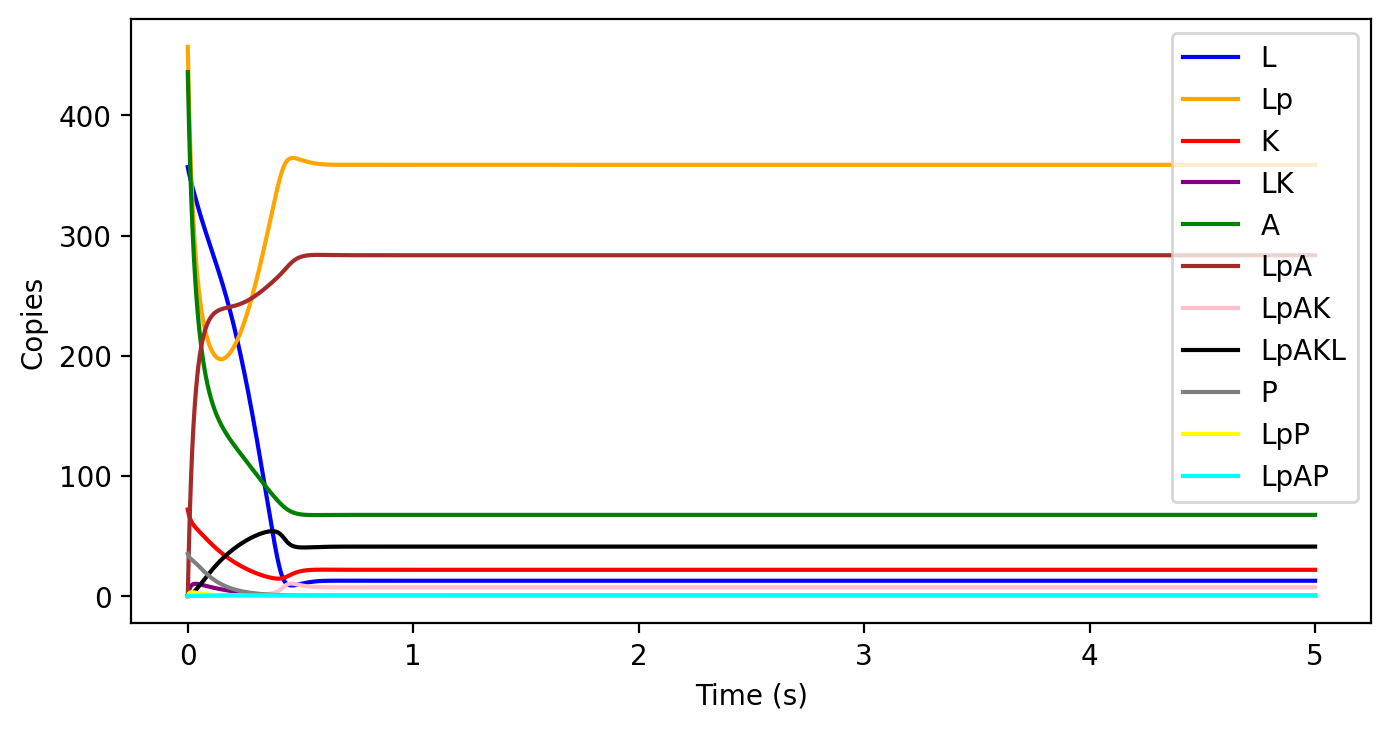

In [7]:
s = 5 #range in seconds that you want to run simulation over
t = np.linspace(0, s, num=10000)


VA = Reaction.getVolume() #gets volume to area ratio from NERDSS parms file
sigma = .001 #usually always keep sigma at 0.001 um or 1 nm
y = VA/(sigma) #gamma is scaling factor on 2D reactions

ka_range = 50
kb_range = 100
kcat_range = 100

## L + K <-> LK --> Lp + K
ka1 = random.uniform(0.0,ka_range)
kb1 = random.uniform(0.0,kb_range)
kcat1 = random.uniform(0.0,kcat_range)
rxn1 = Reaction(('L','K'),[ka1,kb1,kcat1])

## Lp + A <-> LpA
ka2 = random.uniform(0.0,ka_range)
kb2 = random.uniform(0.0,kb_range)
rxn2 = Reaction(('Lp','A'),[ka2,kb2])

## LpA + K <-> LpAK
ka3 = random.uniform(0.0,ka_range)
kb3 = random.uniform(0.0,kb_range)
rxn3 = Reaction(('LpA','K'),[ka3,kb3])

## LpAK + L <-> LpAKL --> LpAK + Lp
ka4 = ka1
kb4 = kb1
kcat4 = kcat1
rxn4 = Reaction(('LpAK','L'),[ka4,kb4,kcat4])

## Lp + P <-> LpP --> L + P
ka5 = random.uniform(0.0,ka_range)
kb5 = random.uniform(0.0,kb_range)
kcat5 = random.uniform(0.0,kcat_range)
rxn5 = Reaction(('Lp','P'),[ka5,kb5,kcat5])

## LpA + P <-> LpAP
ka6 = random.uniform(0.0,ka_range)
kb6 = random.uniform(0.0,kb_range)
rxn6 = Reaction(('LpA','P'),[ka6,kb6])

## LpAP + Lp <-> LpAPLp --> LpAP + L
ka7 = ka5
kb7 = kb5
kcat7 = kcat5
rxn7 = Reaction(('LpAP','Lp'),[ka7,kb7,kcat7])

## Lp + AK <-> LpAK
ka8 = ka2
kb8 = kb2 
rxn8 = Reaction(('Lp','AK'),[ka8,kb8])

## Lp + AP <-> LpAP
ka9 = ka2
kb9 = kb2 
rxn9 = Reaction(('Lp','AP'),[ka9,kb9])


params = {'ka1':rxn1.kaf, 'kb1':rxn1.koff, 'kcat1':rxn1.kcat, 'ka2':rxn2.kaf,'kb2':rxn2.koff,'ka3':rxn3.kaf,
             'kb3':rxn3.koff,'ka4':rxn4.kaf,'kb4':rxn4.koff,'kcat4':rxn4.kcat,'ka5':rxn5.kaf,'kb5':rxn5.koff,'kcat5':rxn5.kcat,'ka6':rxn6.kaf,'kb6':rxn6.koff,
             'ka7':rxn7.kaf,'kb7':rxn7.koff,'kcat7':rxn7.kcat,'ka8':rxn8.kaf,'kb8':rxn8.koff,'ka9':rxn9.kaf,'kb9':rxn9.koff,'y':y}

nerdss_params = {p: globals()[p] for p in list(params.keys())}

#initial copy numbers
L = random.randint(50,1000)
Lp = random.randint(0,1000-L)
K = random.randint(10,200)
LK = 0
A = random.randint(50,500)
LpA = 0
LpAK = 0
LpAKL = 0
P = random.randint(10,200)
LpP = 0
LpAP = 0
LpAPLp = 0
AK = 0
AP = 0

#package copy numbers into dictionary
initial_populations = {'L':L,'Lp':Lp,'K':K,'LK':LK,'A':A,'LpA':LpA,'LpAK':LpAK,'LpAKL':LpAKL,'P':P,'LpP':LpP,'LpAP':LpAP,'LpAPLp':LpAPLp, 'AK':AK, 'AP':AP}

#function that is repeatedly called by our ODE solver
def calculate_current_population_change_rates(t,current_counts, params):

    L = current_counts[0] 
    Lp = current_counts[1]
    K = current_counts[2]
    LK = current_counts[3]
    A = current_counts[4]
    LpA = current_counts[5]
    LpAK = current_counts[6]
    LpAKL = current_counts[7]
    P = current_counts[8]
    LpP = current_counts[9]
    LpAP = current_counts[10]
    LpAPLp = current_counts[11]
    AK = current_counts[12]
    AP = current_counts[13]
   

    ka1 = params[0]
    kb1 = params[1]
    kcat1 = params[2]

    ka2 = params[3]
    kb2 = params[4]

    ka3 = params[5]
    kb3 = params[6]

    ka4 = params[7]
    kb4 = params[8]
    kcat4 = params[9]

    ka5 = params[10]
    kb5 = params[11]
    kcat5 = params[12]

    ka6 = params[13]
    kb6 = params[14]

    ka7 = params[15]
    kb7 = params[16]
    kcat7 = params[17]

    ka8 = params[18]
    kb8 = params[19]
    
    ka9 = params[20]
    kb9 = params[21]

    y = params[22]


    dL = (kb1*LK) - (ka1*L*K) + (kb4*LpAKL) - (y*ka4*LpAK*L) + (kcat5*LpP) + (kcat7*LpAPLp)
    dLp = (kcat1*LK) - (ka2*Lp*A) + (kb2*LpA) + (kcat4*LpAKL) + (kb5*LpP) - (ka5*Lp*P) - (y*ka7*Lp*LpAP) + (kb7*LpAPLp) - (ka2*Lp*AK) + (kb2*LpAK) - (ka2*Lp*AP) + (kb2*LpAP)
    dK = (kb1*LK) - (ka1*L*K) + (kcat1*LK) - (ka3*LpA*K) + (kb3*LpAK)
    dLK = (ka1*L*K) - (kb1*LK) - (kcat1*LK)
    dA = (kb2*LpA) - (ka2*Lp*A)
    dLpA = (ka2*Lp*A) - (kb2*LpA) + (kb3*LpAK) - (ka3*LpA*K) - (ka6*LpA*P) + (kb6*LpAP)
    dLpAK = (ka3*LpA*K) - (kb3*LpAK) + (kb4*LpAKL) - (y*ka4*LpAK*L) + (kcat4*LpAKL) - (kb2*LpAK) + (ka2*Lp*AK)
    dLpAKL = (y*ka4*LpAK*L) - (kb4*LpAKL) - (kcat4*LpAKL)
    dP = (kb5*LpP) + (kcat5*LpP) - (Lp*P*ka5) -(ka6*LpA*P) + (kb6*LpAP)
    dLpP = (ka5*Lp*P) - (kb5*LpP) - (kcat5*LpP)
    dLpAP = (ka6*LpA*P) - (kb6*LpAP) - (y*ka7*Lp*LpAP) + (kb7*LpAPLp) + (kcat7*LpAPLp) - (kb2*LpAP) + (ka2*Lp*AP)
    dLpAPLp = (y*ka7*Lp*LpAP) - (kb7*LpAPLp) - (kcat7*LpAPLp)
    dAK = (kb2*LpAK)-(ka2*Lp*AK)
    dAP = (kb2*LpAP)-(ka2*Lp*AP)

    return([dL, dLp, dK, dLK, dA, dLpA, dLpAK, dLpAKL, dP, dLpP, dLpAP, dLpAPLp, dAK, dAP])	

#call our ODE solver with BDF stiff system algorithm
sol = solve_ivp(fun=calculate_current_population_change_rates,method='BDF', t_span=(0, s), y0=list(initial_populations.values()), t_eval = t,args=(list(params.values()),),
            rtol=1e-6, atol=1e-9)
solutions = sol.y

#Plot the two population counts over time
#########################################
fig = plt.figure(figsize=(8,4),dpi=200)

plt.plot(t,solutions[0,:], color="b", label = 'L')
plt.plot(t,solutions[1,:], color="orange", label = 'Lp')
plt.plot(t,solutions[2,:], color="r", label = 'K')
plt.plot(t,solutions[3,:], color="purple", label = 'LK')
plt.plot(t,solutions[4,:], color="g", label = 'A')
plt.plot(t,solutions[5,:], color="brown", label = 'LpA')
plt.plot(t,solutions[6,:], color="pink", label = 'LpAK')
plt.plot(t,solutions[7,:], color="black", label = 'LpAKL')
plt.plot(t,solutions[8,:], color="grey", label = 'P')
plt.plot(t,solutions[9,:], color="yellow", label = 'LpP')
plt.plot(t,solutions[10,:], color="cyan", label = 'LpAP')

plt.xlabel('Time (s)')
plt.ylabel('Copies')
plt.legend()

print(params)
print(initial_populations)
print(f'Reaction 1 Km: {rxn1.Km}')
print(f'Reaction 5 Km: {rxn5.Km}')
print(f'Km Ratio: {rxn1.Km/rxn5.Km}')
plt.show()

### Run this automatation cell after you like your randomized parameters

In [8]:
auto = Automate(nerdss_params,initial_populations,solutions,s) #Automation routine automatically writes parms file and runs NERDSS simulation.
#however, this only operates within the current directory, so only run it in a new directory dedicated to a new set of params. Make a numbered copy of the directory each time you want to run different params

#if you rerun the ODE solver cell above, your randomized parameters will change and not match NERDSS... 
#but your old params will still be saved in "parms.json" within your current working directory. Use auto.load_parms() to retrieve in dictionary form

# COMPARE

## Compare class. Run this after NERDSS has finished

In [27]:
from ctypes import Array


class Compare:
    def __init__(self, week: str):
        self.week = week
        self.t = np.load("t.npy")
        self.nerdss_params = Automate.load_parms()
        self.ode_solutions = np.load("ode_solutions.npy")
        self.ordered_cols = ['Time (s)','L','Lp', 'K', 'LK', 'A', 'LpA', 'LpAK', 'LpAKL', 'P', 'LpP', 'LpAP', 'LpAPLp','AK','AP']
        self.copy_df = self.read_copynumbers()
        self.hist_df = self.read_histogram()
        self.sol_df = self.read_ode_solutions()
        self.plot()

    def read_copynumbers(self):
        return pd.read_csv('copy_numbers_time.dat')

    def read_histogram(self):
        with open('histogram_complexes_time.dat', 'r') as file:
            #perms = set()
            newrowlist = []
            newrow = {}
            for i,line in enumerate(file):
                if "Time" in line:
                    if i > 0:
                        #hist_df = pd.concat([hist_df,pd.DataFrame([newrow])], ignore_index=True)
                        newrowlist.append(newrow)
                        newrow = {} #clear dictionary at each time step

                    linesplit = line.split(' ')
                    time = linesplit[-1].split('\n')[-2]
                    newrow['Time (s)'] = float(time)
                else:            
                    linesplit = line.split('\t')

                    amount, string = int(linesplit[0]), linesplit[1]
                    #perms.add(string)

                    if string == 'pip2: 1. \n':
                        newrow['Lp'] = amount
                    elif string == 'pip2: 1. ap2: 1. syn: 1. \n':
                        newrow['LpAP'] = amount
                    elif string == 'pip2: 2. ap2: 1. syn: 1. \n':
                        newrow['LpAPLp'] = amount
                    elif string == 'ap2: 1. \n':
                        newrow['A'] = amount
                    elif string == 'kin: 1. \n':
                        newrow['K'] = amount
                    elif string == 'syn: 1. \n':
                        newrow['P'] = amount
                    elif string == 'pip2: 1. ap2: 1. \n':
                        newrow['LpA'] = amount 
                    elif string == 'pip2: 1. syn: 1. \n':
                        newrow['LpP'] = amount 
                    elif string == 'pip2: 2. kin: 1. ap2: 1. \n':
                        newrow['LpAKL'] = amount 
                    elif string == 'pip2: 1. kin: 1. \n':
                        newrow['LK'] = amount 
                    elif string == 'pip2: 1. kin: 1. ap2: 1. \n':
                        newrow['LpAK'] = amount 
                    elif string == 'kin: 1. ap2: 1. \n':
                        newrow['AK'] = amount
                    elif string == 'ap2: 1. syn: 1. \n':
                        newrow['AP'] = amount
            
        #print(perms)
        hist_df = pd.DataFrame.from_dict(newrowlist)
        hist_df = hist_df.fillna(0)
        hist_df = hist_df.iloc[0::int(len(hist_df)/len(self.t))]
        hist_df['L'] = self.copy_df['pip2(head~U)']
        hist_df['Lp'] = self.copy_df['pip2(head~P)']
        for mol in self.ordered_cols:
            if mol not in hist_df:
                hist_df[mol]=0
        hist_df = hist_df[self.ordered_cols]
        
        return hist_df

    def read_ode_solutions(self):
        return pd.DataFrame(self.ode_solutions.T, columns= self.ordered_cols[1:])

    def get_eucdistance(self):
        hist_arr = self.hist_df.loc[:,self.hist_df.columns!='Time (s)'].to_numpy()
        sol_arr = self.sol_df.to_numpy()

        euc_dist = np.linalg.norm(hist_arr-sol_arr)
        new_entry = self.nerdss_params
        new_entry['euc_dist'] = euc_dist
        new_entry['dir'] = os.path.basename(os.getcwd())

        recordfile = "/home/local/WIN/jfisch27/Desktop/rand_ka_params.txt" #CHANGE this PATH to whatever file you want to record results in. This will be used for our statistical analysis after enough data points
        # if os.path.exists(recordfile):
        with open(recordfile,'a') as file:
            fieldnames = self.nerdss_params.keys()
            writer = csv.DictWriter(file,fieldnames=fieldnames)
            # writer.writeheader() #UNCOMMENT IF RUNNING FIRST TIME. THIS GIVES THE HEADERS SO YOU KNOW WHAT COLUMNS ARE 
            writer.writerow(self.nerdss_params)

        return euc_dist

    def plot(self):
        fig = plt.figure(figsize=(8,4),dpi=200)

        plt.plot(self.t,self.sol_df['L'], color="b", label = 'L') #need to get column name)
        plt.plot(self.t,self.sol_df['Lp'], color="orange", label = 'Lp')
        plt.plot(self.t,self.sol_df['K'], color="gold", label = 'K')
        plt.plot(self.t,self.sol_df['LK'], color="purple", label = 'LK')
        plt.plot(self.t,self.sol_df['A'], color="r", label = 'A')
        plt.plot(self.t,self.sol_df['LpA'], color="g", label = 'LpA')
        plt.plot(self.t,self.sol_df['LpAK'], color="pink", label = 'LpAK')
        plt.plot(self.t,self.sol_df['LpAKL'], color="brown", label = 'LpAKL')
        plt.plot(self.t,self.sol_df['P'], color="cyan", label = 'P')
        plt.plot(self.t,self.sol_df['LpP'], color="magenta", label = 'LpP')
        plt.plot(self.t,self.sol_df['LpAP'], color="black", label = 'LpAP')
        plt.plot(self.t,self.sol_df['LpAPLp'], color="gray", label = 'LpAPLp')



        plt.plot(self.hist_df['Time (s)'], self.hist_df['L'], color = 'b', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['Lp'], color = 'orange', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['K'], color = 'gold', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['LK'], color = 'purple', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['A'], color = 'r', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['LpA'], color = 'g', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['LpAK'], color = 'pink', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['LpAKL'], color = 'brown', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['P'], color = 'cyan', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['LpP'], color = 'magenta', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['LpAP'], color = 'black', linestyle = 'dashed', alpha = 0.7)
        plt.plot(self.hist_df['Time (s)'], self.hist_df['LpAPLp'], color = 'gray', linestyle = 'dashed', alpha = 0.7)


        plt.title(f"Euclidean distance: {self.get_eucdistance()}")
        plt.xlabel('Time (s)')
        plt.ylabel('Copies')
        plt.legend()

        week = self.week #WORK WEEK FOR SUBDIRECTORY, LIKE "9-21-22"
        img_folder = os.path.join("/home/local/WIN/jfisch27/Desktop/Oscillator/IMAGES", week) ##CHANGE THE FIRST ARG TO WHATEVER DIRECTORY KEEPS YOUR IMAGES
        if not os.path.isdir(img_folder):
            os.makedirs(img_folder)
        img_path = os.path.join(img_folder,os.path.basename(os.getcwd()))
        plt.savefig(img_path)
        plt.show()

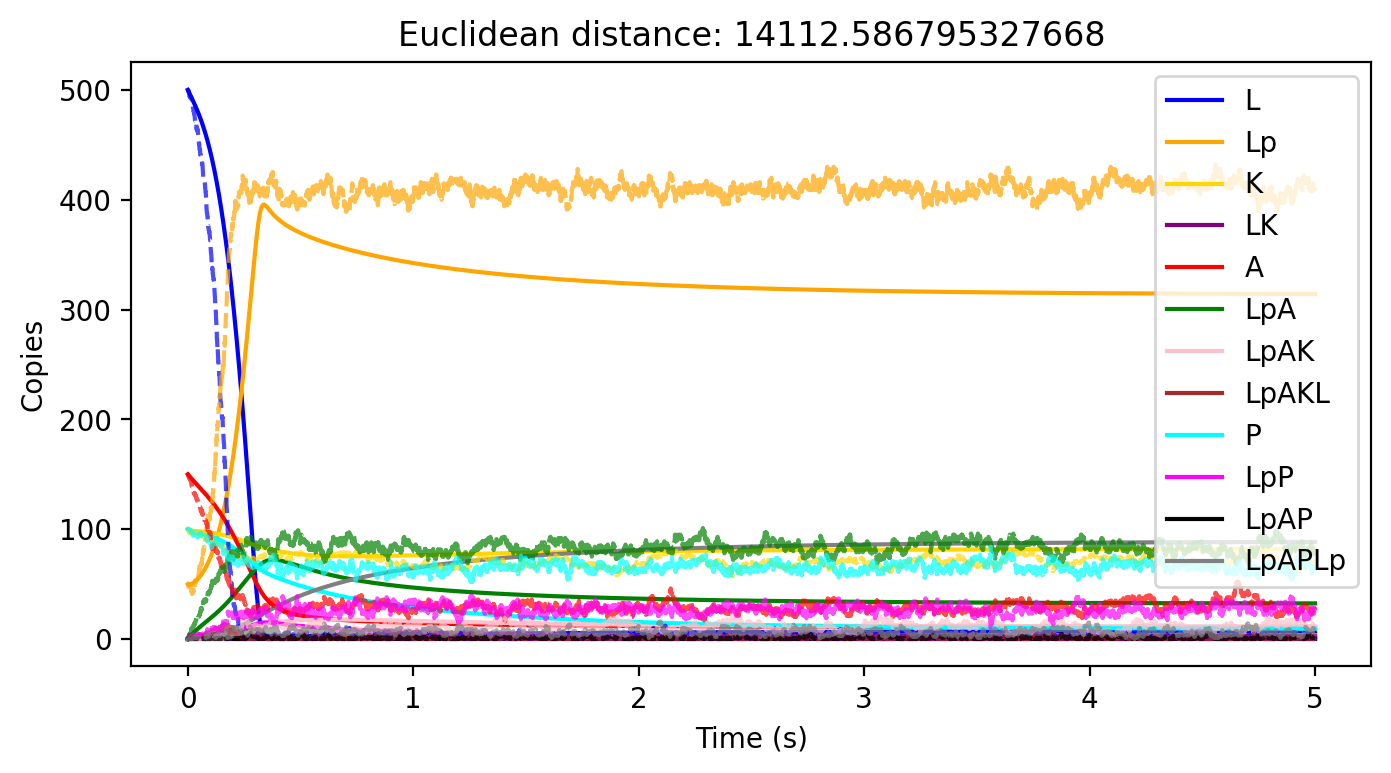

In [28]:
compare = Compare("9-29-22") 